# Task 2.3 - Physics-augmented neural network model

## Setup

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from typing import Literal
from copy import deepcopy
from keras import optimizers
from keras import losses
from keras import metrics
from pprint import pprint

from src.models import InvariantsICNN
from src.data_import import load_paml_dataset, load_data
from src.plots import plot_stress_predictions, plot_energy_prediction, plot_loss, plot_heatmap
from src.utils import get_scores
from src.predict_utils import predict_multi_cases_PANN, predict_identity_F_PANN

2024-12-03 13:59:10.469893: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 13:59:10.473840: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 13:59:10.486530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 13:59:10.508993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 13:59:10.514125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 13:59:10.527579: I tensorflow/core/platform/cpu_feature_gu

### Paths

In [2]:
# Calibration paths
calibration_dir = os.path.abspath('calibration')
biaxial_path = os.path.join(calibration_dir, 'biaxial.txt')
pure_shear_path = os.path.join(calibration_dir, 'pure_shear.txt')
uniaxial_path = os.path.join(calibration_dir, 'uniaxial.txt')

# Test paths
test_dir = os.path.abspath('test')
biax_test_path = os.path.join(test_dir, 'biax_test.txt')
mixed_test_path = os.path.join(test_dir, 'mixed_test.txt')

### Load Datasets

In [3]:
biaxial_F, biaxial_P, biaxial_W = load_data(biaxial_path)
pure_shear_F, pure_shear_P, pure_shear_W = load_data(pure_shear_path)
uniaxial_F, uniaxial_P, uniaxial_W = load_data(uniaxial_path)

biax_test_F, biax_test_P, biax_test_W = load_data(biax_test_path)
mixed_test_F, mixed_test_P, mixed_test_W = load_data(mixed_test_path)

train_FPW_tup = {
    'biaxial': (biaxial_F, biaxial_P, biaxial_W),
    'pure_shear': (pure_shear_F, pure_shear_P, pure_shear_W),
    'uniaxial': (uniaxial_F, uniaxial_P, uniaxial_W)
}

test_FPW_tup = {
    'biaxial': (biax_test_F, biax_test_P, biax_test_W),
    'mixed': (mixed_test_F, mixed_test_P, mixed_test_W),
}

## PANN calibration on stress Tensors $P$

In [4]:
train_stress_features = tf.concat([biaxial_F, pure_shear_F, uniaxial_F], axis=0)
train_stress_labels = tf.concat([biaxial_P, pure_shear_P, uniaxial_P], axis=0)

/home/argo/envs/forl_env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


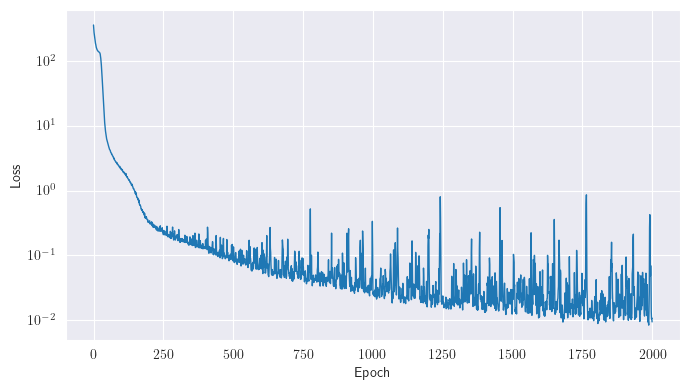

In [5]:
pann_stress_model = InvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_derivative=True
)
pann_stress_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
pann_stress_h = pann_stress_model.fit(
    train_stress_features, train_stress_labels, batch_size=32, epochs=2000, verbose=0
)
pann_stress_loss = pann_stress_h.history['loss']
plot_loss(pann_stress_loss)

### Model Evaluation

#### -- predict on seen load cases

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


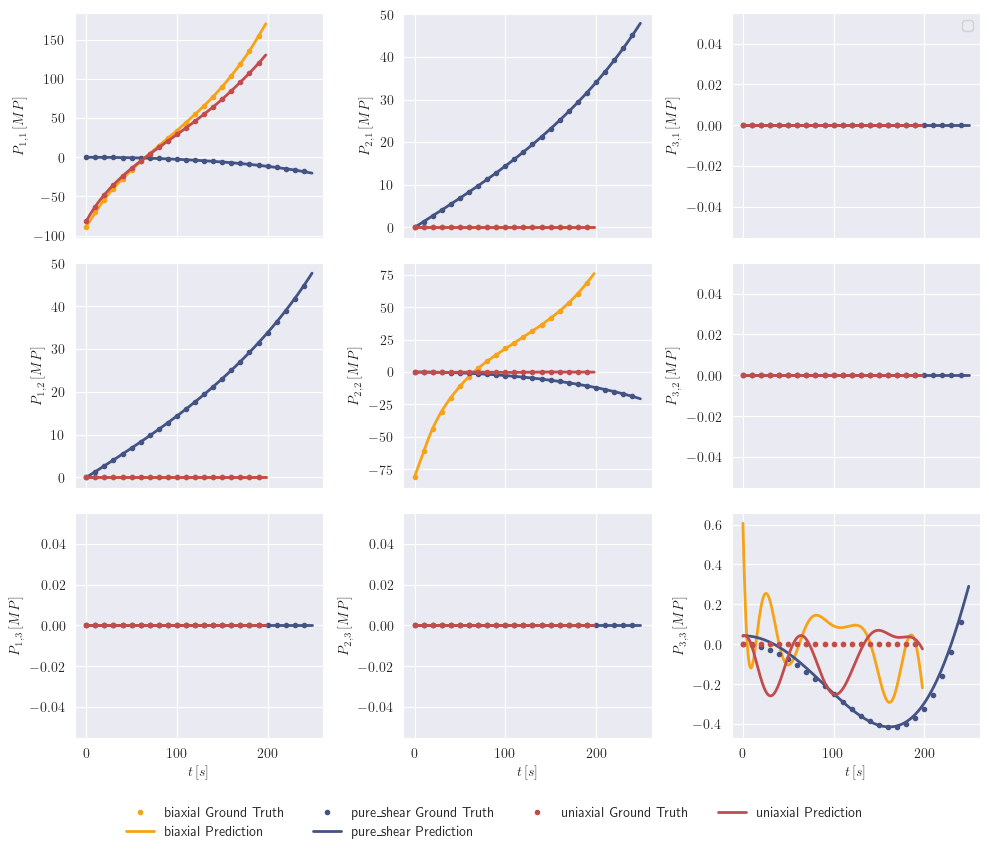

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


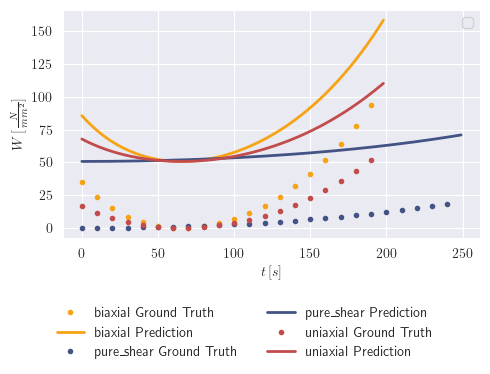

In [ ]:
(P_stress_train_labels, W_stress_train_labels, P_stress_train_preds, W_stress_train_preds
 ) = predict_multi_cases_PANN(pann_stress_model, train_FPW_tup)
plot_stress_predictions(P_stress_train_labels, P_stress_train_preds)
plot_energy_prediction(W_stress_train_labels, W_stress_train_preds)

#### -- predict on unseen load cases

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


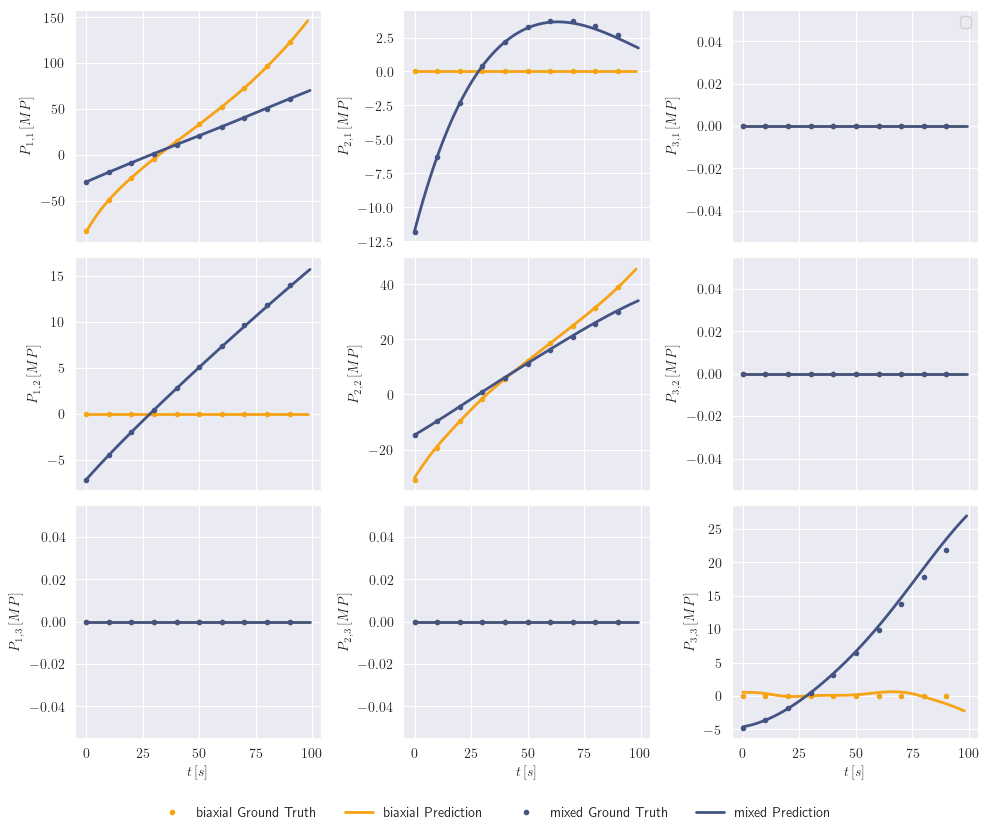

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


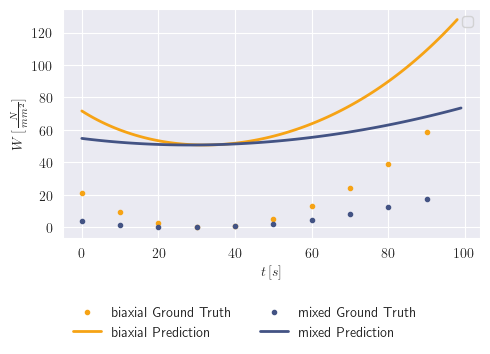

In [ ]:
(P_stress_test_labels, W_stress_test_labels, P_stress_test_preds, W_stress_test_preds
 ) = predict_multi_cases_PANN(pann_stress_model, test_FPW_tup)
plot_stress_predictions(P_stress_test_labels, P_stress_test_preds)
plot_energy_prediction(W_stress_test_labels, W_stress_test_preds)

## Test $F=I$ for stress and energy

### PANN calibration on stress Tensor $P$

In [ ]:
predict_identity_F_PANN(pann_stress_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
P predicted: 
[[[-0.03940964  0.          0.        ]
  [ 0.          0.04279327  0.        ]
  [ 0.          0.          0.04279327]]]
W predicted: 
[[50.732166]]


### PANN calibration on energy $W$

In [9]:
train_energy_features = tf.concat([biaxial_F, pure_shear_F, uniaxial_F], axis=0)
train_energy_labels = tf.concat([biaxial_W, pure_shear_W, uniaxial_W], axis=0)

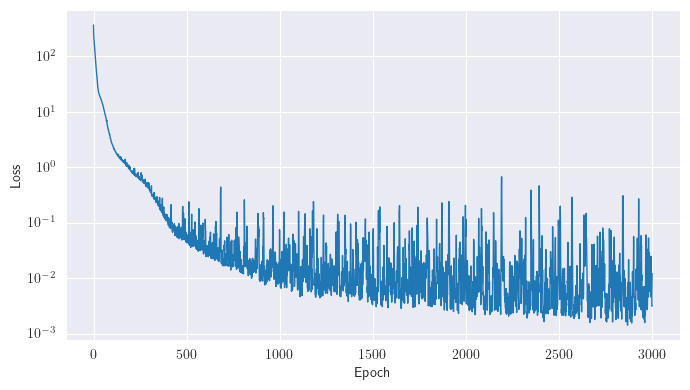

In [10]:
pann_energy_model = InvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_derivative=False
)
pann_energy_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
pann_energy_h = pann_energy_model.fit(
    train_energy_features, train_energy_labels, batch_size=32, epochs=3000, verbose=0
)
pann_energy_loss = pann_energy_h.history['loss']
plot_loss(pann_energy_loss)

In [ ]:
predict_identity_F_PANN(pann_energy_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
P predicted: 
[[[-0.29332352  0.          0.        ]
  [ 0.          0.27057266  0.        ]
  [ 0.          0.          0.27057266]]]
W predicted: 
[[0.05740452]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


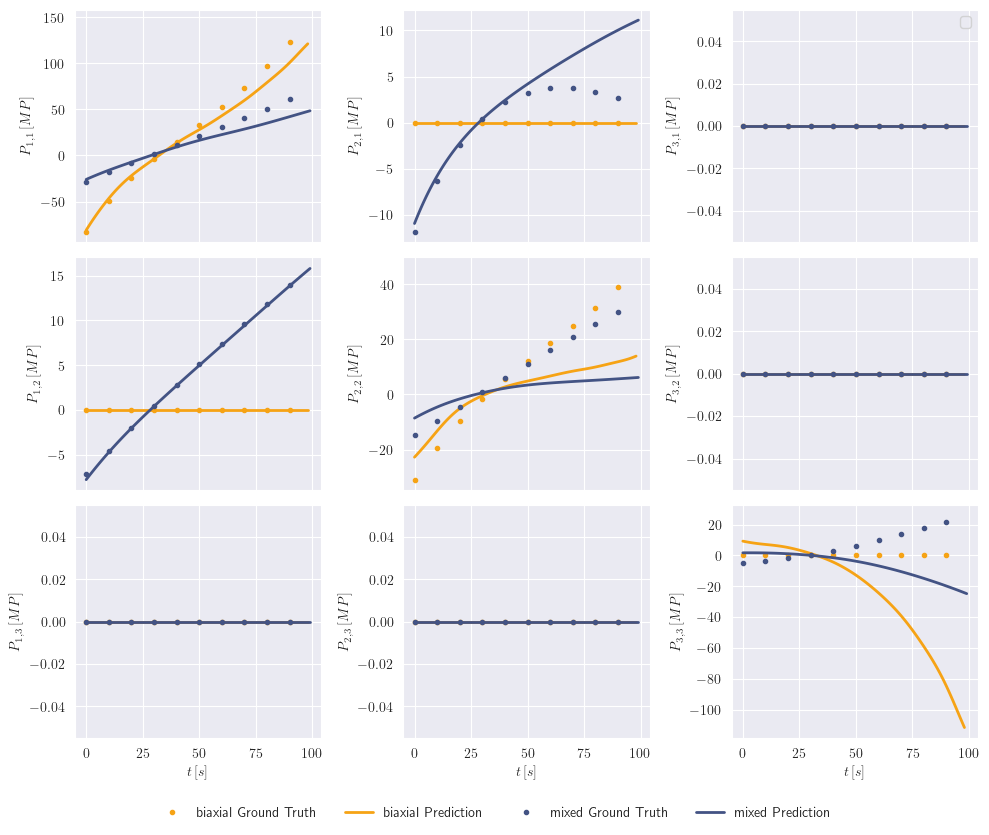

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


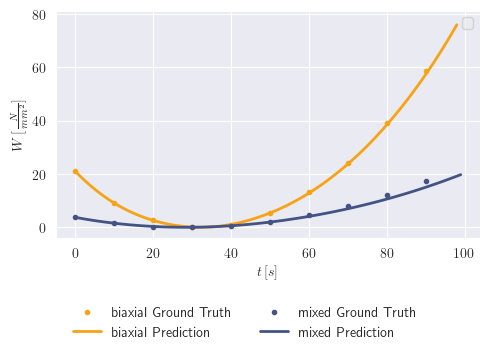

In [ ]:
(P_energy_test_labels, W_energy_test_labels, P_energy_test_preds, W_energy_test_preds
 ) = predict_multi_cases_PANN(pann_energy_model, test_FPW_tup)
plot_stress_predictions(P_energy_test_labels, P_energy_test_preds)
plot_energy_prediction(W_energy_test_labels, W_energy_test_preds)

### PANN calibration on stress $P$ and energy $W$

In [13]:
train_both_features = tf.concat([biaxial_F, pure_shear_F, uniaxial_F], axis=0)
train_both_labels = (
    tf.concat([biaxial_W, pure_shear_W, uniaxial_W], axis=0), 
    tf.concat([biaxial_P, pure_shear_P, uniaxial_P], axis=0)
)

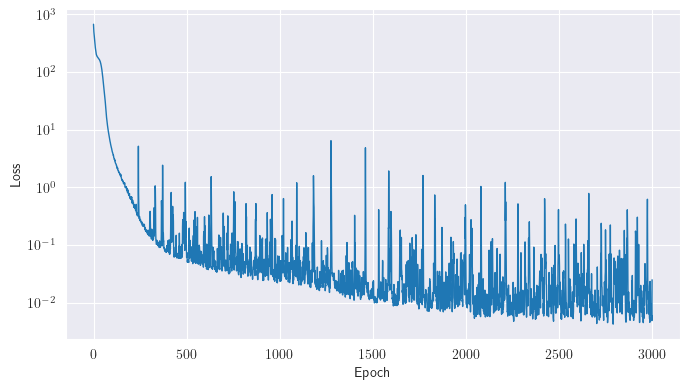

In [14]:
pann_both_model = InvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_output_and_derivative=True
)
pann_both_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
pann_energy_h = pann_both_model.fit(
    train_both_features, train_both_labels, batch_size=32, epochs=3000, verbose=0
)
pann_energy_loss = pann_energy_h.history['loss']
plot_loss(pann_energy_loss)

In [ ]:
predict_identity_F_PANN(pann_both_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
P predicted: 
[[[ 0.06499481  0.          0.        ]
  [ 0.         -0.04440308  0.        ]
  [ 0.          0.         -0.04440308]]]
W predicted: 
[[-0.00991058]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


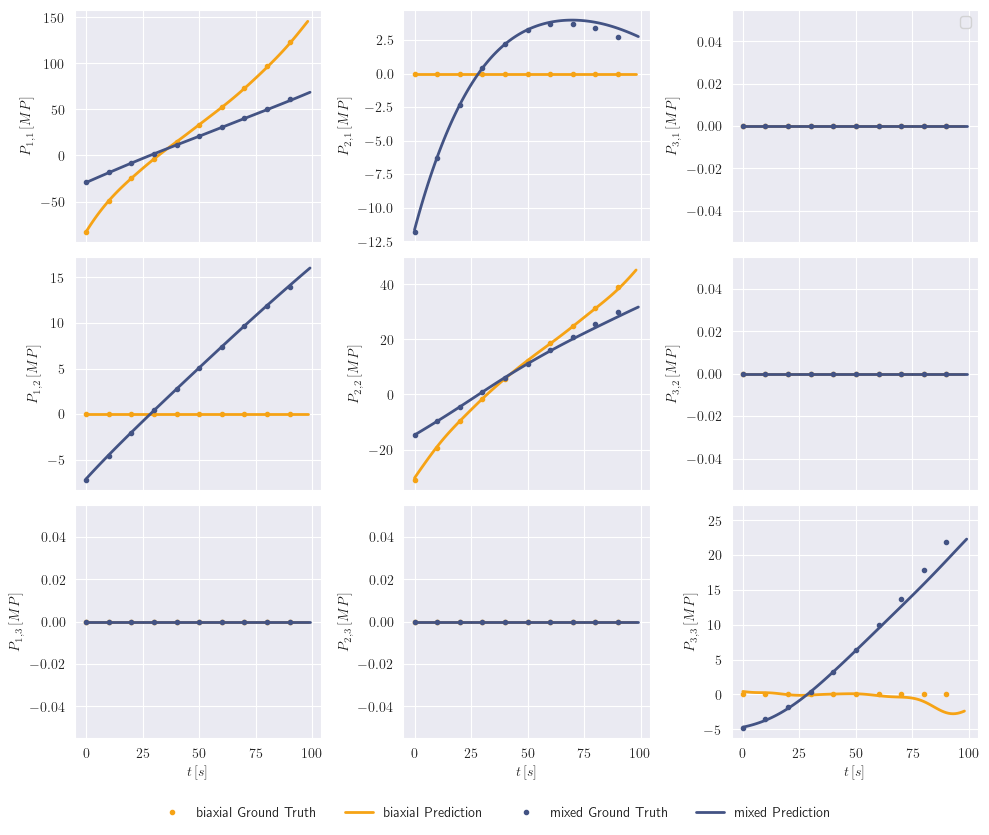

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


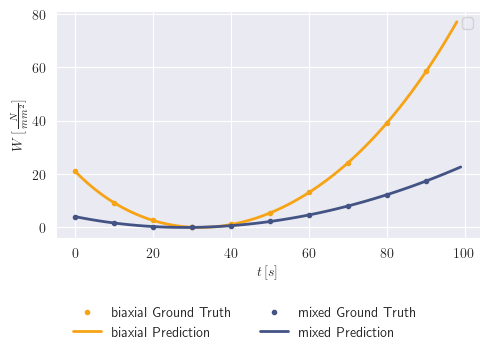

In [ ]:
(P_both_test_labels, W_both_test_labels, P_both_test_preds, W_both_test_preds
 ) = predict_multi_cases_PANN(pann_both_model, test_FPW_tup)
plot_stress_predictions(P_both_test_labels, P_both_test_preds)
plot_energy_prediction(W_both_test_labels, W_both_test_preds)

## Model calibration on one load case

In [17]:
train_one_features = uniaxial_F
train_one_labels = uniaxial_P

/home/argo/envs/forl_env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


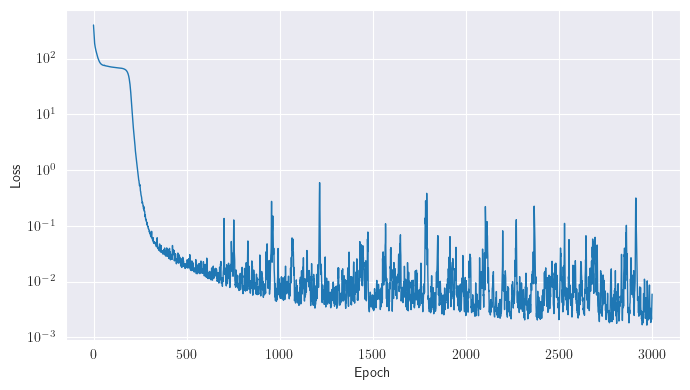

In [18]:
pann_one_model = InvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear']
)
pann_one_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
one_h = pann_one_model.fit(
    train_one_features, train_one_labels, batch_size=32, epochs=3000, verbose=0)
one_loss = one_h.history['loss']
plot_loss(one_loss)

### Model Evaluation

#### -- on seen load cases

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


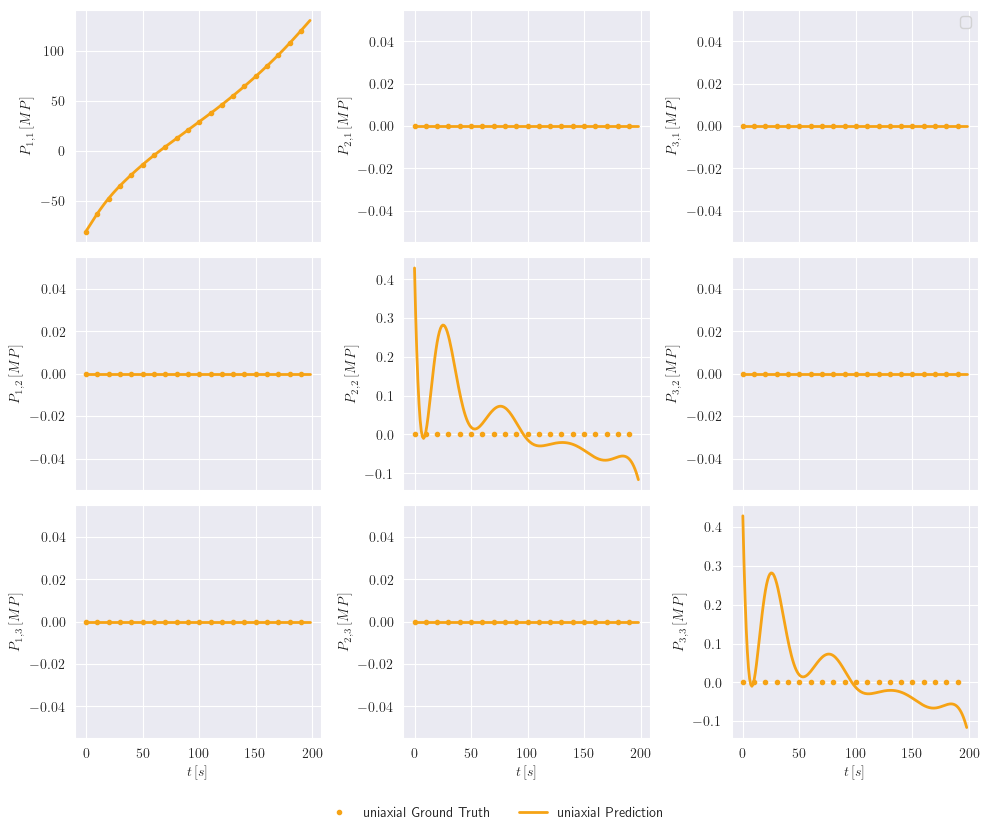

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


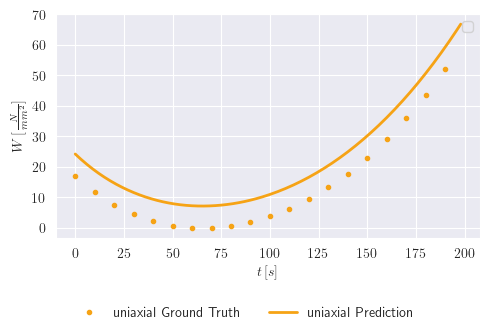

In [ ]:
train_test_one_FPW_tup = deepcopy(train_FPW_tup)
train_one_FPW_tup = train_test_one_FPW_tup.pop('uniaxial')
(P_one_train_labels, W_one_train_labels, P_one_train_preds, W_one_train_preds
 ) = predict_multi_cases_PANN(pann_one_model, {'uniaxial': train_one_FPW_tup})
plot_stress_predictions(P_one_train_labels, P_one_train_preds)
plot_energy_prediction(W_one_train_labels, W_one_train_preds)

#### -- on unseen load cases

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


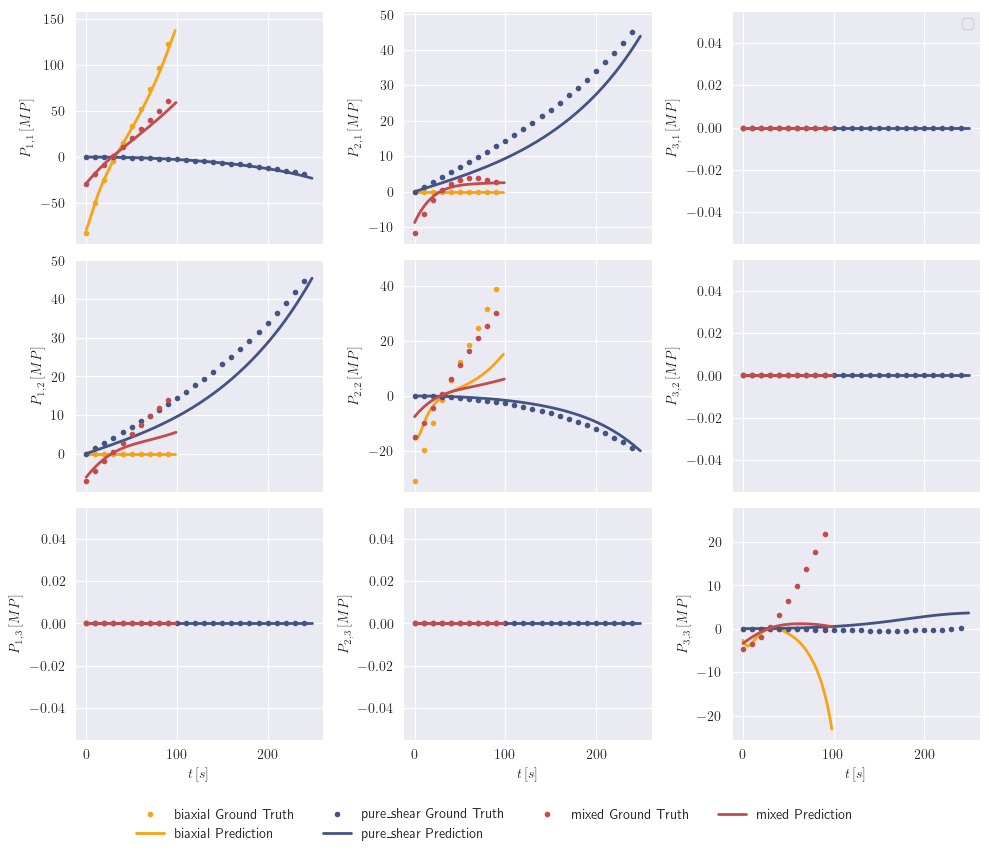

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


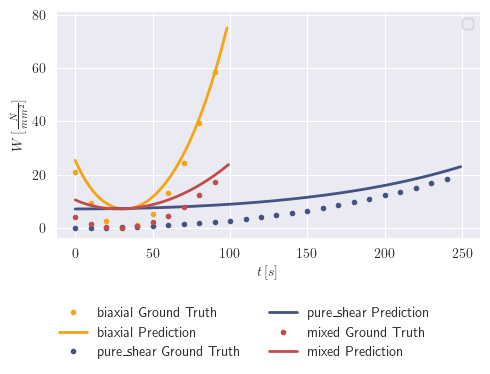

In [ ]:
test_one_FWP_tup = deepcopy(train_test_one_FPW_tup)
test_one_FWP_tup.update(test_FPW_tup)
(P_one_test_labels, W_one_test_labels, P_one_test_preds, W_one_test_preds
 ) = predict_multi_cases_PANN(pann_one_model, test_one_FWP_tup)
plot_stress_predictions(P_one_test_labels, P_one_test_preds)
plot_energy_prediction(W_one_test_labels, W_one_test_preds)